In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

import sqlite3
import sys
import time
import tqdm
from tqdm.auto import tqdm
import pickle
import joblib
import os

if os.path.exists('/workspace/data'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data/'
else:
    data_path = '../data/'


## Loading SQLite Database into Pandas DataFrames

The following code connects to an SQLite database (`melee_player_database.db`) and converts each table within the database into a pandas DataFrame. The DataFrames will be stored in a dictionary, where each key corresponds to the table name with `_df` appended, and the values are the respective DataFrames.

### Steps:

1. **Database Connection**: We use the `sqlite3` library to connect to the SQLite database file.
2. **Retrieve Table Names**: A query retrieves all the table names in the database.
3. **Convert Tables to DataFrames**: For each table:
   - The table is loaded into a pandas DataFrame using `pd.read_sql()`.
   - We check each column to see if any data is JSON-formatted (lists or dictionaries). If so, we convert these columns from strings into their corresponding Python objects using `json.loads()`.
4. **Store DataFrames**: The DataFrames are stored in a dictionary, where the key is the table name with a `_df` suffix, and the value is the DataFrame.
5. **Database Connection Closed**: Once all tables are loaded into DataFrames, the database connection is closed.

### Example:
If the database contains a table named `players`, the corresponding DataFrame will be stored in the dictionary with the key `players_df`, and can be accessed as:

```python
players_df = dfs['players_df']


In [2]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

if os.path.exists(data_path + 'dfs_dict.pkl'):
    cell_has_run = True
    # Load the dictionary of DataFrames from the pickle
    with open(data_path + 'dfs_dict.pkl', 'rb') as f:
        dfs = pickle.load(f)
# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = + data_path + "melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

### Here we adjust the data types of the dataframes so that they are the correct type. (This will be updated as needed.)

In [3]:
dfs['sets_df']['best_of'] = dfs['sets_df']['best_of'].fillna(0).astype(int) 

In [4]:
# # Save the dictionary of DataFrames as a pickle
# with open(data_path + 'dfs_dict.pkl', 'wb') as f:
#     pickle.dump(dfs, f)

### Here we make dataframes that we will use and print the head.

The integers in 'characters' count the number of games the player has played that character. (We verify this for Zain below.)

In [132]:
players_df = dfs['players_df']

players_df[players_df['tag'] == 'Mang0'].head()



,game,player_id,tag,all_tags,prefixes,social,country,state,region,c_country,c_state,c_region,placings,characters,alias
102,melee,1000,Mang0,"[C9 | Mango, Mango, C9. Mango, C9|Mango, C9 | ...",[C9],{'twitter': ['C9Mang0']},United States,CA,SoCal,US,CA,Los Angeles,[{'key': 'slippi-champions-league-week-1__mele...,"{'melee/falco': 812, 'melee/fox': 516, 'melee/...",None
57296,melee,148442,Mang0,[Mang0],[C9],{'twitter': []},United States,CA,None,US,CA,None,[{'key': 'c9-mang0-5-2-stock-side-event__two-s...,,None


In [6]:
ranking_df = dfs['ranking_df']
ranking_df.head()

,game,ranking_name,priority,region,seasons,tournaments,icon
0,melee,SSBMRank,0,world,"[2015, 2016, 2017, 2018, 2019]",[],miom


In [7]:
ranking_seasons_df = dfs['ranking_seasons_df']
ranking_seasons_df.head()

,game,ranking_name,season,start,end,total,by_id,by_placing,final,name
0,melee,SSBMRank,2015,1420070400,1451606399,100,"{'6189': 1, '1004': 2, '4465': 3, '1000': 4, '...","{'1': '6189', '2': '1004', '3': '4465', '4': '...",0,None
1,melee,SSBMRank,2016,1451606400,1483228799,100,"{'6189': 1, '1004': 2, '1000': 3, '1003': 4, '...","{'1': '6189', '2': '1004', '3': '1000', '4': '...",0,None
2,melee,SSBMRank,2017,1483228800,1514764799,100,"{'1004': 1, '6189': 2, '1000': 3, '1003': 4, '...","{'1': '1004', '2': '6189', '3': '1000', '4': '...",0,None
3,melee,SSBMRank,2018,1514793600,1546329600,100,"{'1004': 1, '6189': 2, '4465': 3, '15990': 4, ...","{'1': '1004', '2': '6189', '3': '4465', '4': '...",0,None
4,melee,SSBMRank,2019,1546329600,1577836800,100,"{'1004': 1, '4465': 2, '1000': 3, '16342': 4, ...","{'1': '1004', '2': '4465', '3': '1000', '4': '...",0,None


In [8]:
sets_df = dfs['sets_df']
print(f"{sets_df[sets_df['game_data'].apply(lambda x: len(x) > 0)].shape[0] / sets_df.shape[0]:0.01%} percent of sets have some game data")
sets_df.shape



32.9% percent of sets have some game data


(1795681, 14)

In [9]:
tournament_info_df = dfs['tournament_info_df']
tournament_info_df.head()


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,US,MI,Ann Arbor,92,[],{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0


## Games played by character ##
Count the games played by each character and plot.

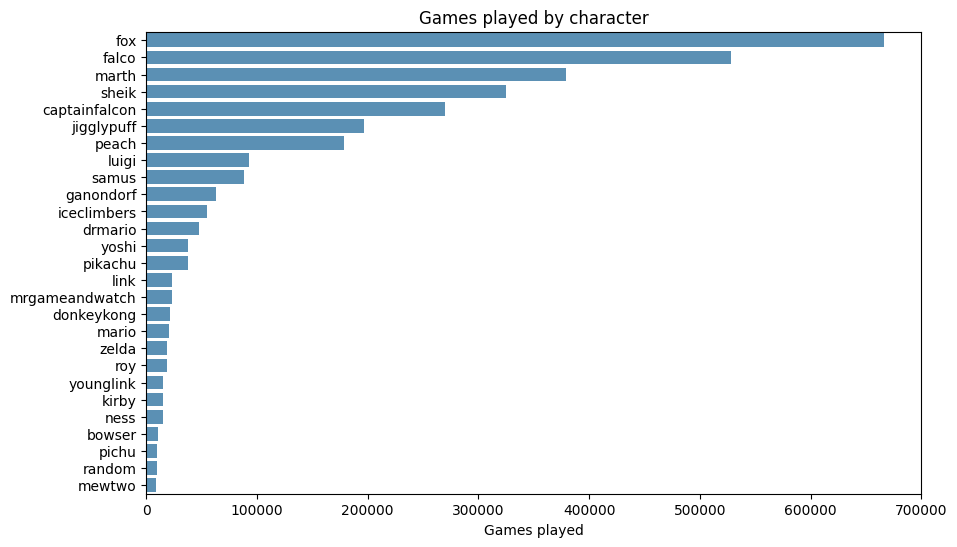

In [10]:
from collections import Counter

# Filter out rows where 'characters' is not a dictionary
valid_rows = players_df[players_df['characters'].apply(lambda x: isinstance(x, dict))]

# Use apply and Counter to aggregate counts
total_character_counts = Counter()

# Sum up all character counts
total_character_counts.update(valid_rows['characters'].apply(Counter).sum())

# Sort by number of games played
total_character_counts = dict(total_character_counts)
sorted_characters = sorted(total_character_counts.items(), key=lambda x: x[1], reverse=True)
sorted_characters = dict([(char.split('/')[1], count) for char, count in sorted_characters])

# Plot the data
plt.figure(figsize=(10,6))
plot = sns.barplot(sorted_characters, orient='h', alpha = .8, capsize=2)
plot.set_title('Games played by character')
plot.set_xlabel('Games played')
plt.show()

## Investigate data for Zain
We choose zain because he is in the best player in the head of the players_df.

In [140]:
zain_df = players_df.iloc[2]
print(zain_df)
print('Zain has played in', len(zain_df['placings']), 'tournaments.')

# Dataframe of tournaments that zain has played in.
zain_tournament_keys = [tournament['key'] for tournament in zain_df['placings']]
zain_tournament_info_df = tournament_info_df[tournament_info_df['key'].isin(zain_tournament_keys)]

game                                                      melee
player_id                                                  6126
tag                                                        Zain
all_tags                                     [Zain, DontTestMe]
prefixes                                                   [PG]
social                                 {'twitter': ['PG_Zain']}
country                                           United States
state                                                        VA
region                                                         
c_country                                                    US
c_state                                                      CA
c_region                                            Los Angeles
placings      [{'key': 'mdva-invitational-2017-(challonge-mi...
characters    {'melee/marth': 1065, 'melee/pichu': 1, 'melee...
alias                                                DontTestMe
Name: 2, dtype: object
Zain has played i

In [12]:
print(zain_tournament_info_df.info())
zain_tournament_info_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 39443
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   game              180 non-null    object        
 1   key               180 non-null    object        
 2   cleaned_name      180 non-null    object        
 3   source            180 non-null    object        
 4   tournament_name   180 non-null    object        
 5   tournament_event  180 non-null    object        
 6   season            180 non-null    object        
 7   rank              180 non-null    object        
 8   start             180 non-null    datetime64[ns]
 9   end               180 non-null    datetime64[ns]
 10  country           126 non-null    object        
 11  state             124 non-null    object        
 12  city              114 non-null    object        
 13  entrants          180 non-null    int64         
 14  placings          180 non-nul

,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0
5,melee,slippi-champions-league-week-4__melee-singles,Slippi Champions League Week 4,pgstats,slippi-champions-league-week-4,melee-singles,20,,2020-10-31 14:00:00,2020-10-31 14:00:00,,,,20,"[[6126, 1], [3357, 2], [15990, 3], [3359, 3], ...",{},b'{}',1,0.0,0.0


Here we make a dataframe containing all the sets that zain has played in and add some columns so that we can identify him more easily.

In [13]:
# Filter sets_df with Zain as a player and make a copy
zain_sets_df = sets_df[(sets_df['p1_id'] == zain_df['player_id']) | (sets_df['p2_id'] == zain_df['player_id'])].copy()
print('Zain has played', zain_sets_df.shape[0], 'sets.')

# Assuming zain_df['player_id'] gives Zain's player ID
zain_id = zain_df['player_id']

# Add a 'zain_win' column using .loc
zain_sets_df.loc[:, 'zain_win'] = ((zain_sets_df['p1_id'] == zain_id) & (zain_sets_df['p1_score'] > zain_sets_df['p2_score'])) | \
                                  ((zain_sets_df['p2_id'] == zain_id) & (zain_sets_df['p2_score'] > zain_sets_df['p1_score']))

# Add an 'opponent' column using .loc
zain_sets_df.loc[:, 'opponent'] = zain_sets_df.apply(
    lambda row: row['p1_id'] if row['p2_id'] == zain_id else row['p2_id'],
    axis=1
)

# Add 'zain_score' and 'opponent_score' columns using .loc
zain_sets_df.loc[:, 'zain_score'] = zain_sets_df.apply(
    lambda row: row['p1_score'] if row['p1_id'] == zain_id else row['p2_score'],
    axis=1
)

zain_sets_df.loc[:, 'opponent_score'] = zain_sets_df.apply(
    lambda row: row['p2_score'] if row['p1_id'] == zain_id else row['p1_score'],
    axis=1
)

# Filter the zain_sets_df for rows where 'game_data' is not an empty list
game_data_zain_sets_df = zain_sets_df[zain_sets_df['game_data'].apply(lambda x: len(x) > 0)]

# Display the result
print('Zain has played', game_data_zain_sets_df.shape[0], 'sets with game_data.')
print(game_data_zain_sets_df.iloc[1]['game_data'])


Zain has played 1344 sets.
Zain has played 575 sets with game_data.
[{'loser_char': 'melee/fox', 'winner_score': 1, 'winner_id': 6126, 'loser_id': 13932, 'winner_char': 'melee/marth', 'loser_score': 0, 'stage': 'Fountain of Dreams'}, {'loser_char': 'melee/marth', 'winner_score': 1, 'winner_id': 13932, 'loser_id': 6126, 'winner_char': 'melee/fox', 'loser_score': 0, 'stage': 'Dream Land'}, {'loser_char': 'melee/fox', 'winner_score': 2, 'winner_id': 6126, 'loser_id': 13932, 'winner_char': 'melee/marth', 'loser_score': 0, 'stage': 'Final Destination'}, {'loser_char': 'melee/fox', 'winner_score': 2, 'winner_id': 6126, 'loser_id': 13932, 'winner_char': 'melee/marth', 'loser_score': 0, 'stage': "Yoshi's Story"}]


Here we check to see that zain_df['characters'] counts the number of games that zain has played that character.

In [14]:
loser_char = [game_data_dict['loser_char'] for game_data_dict in game_data_zain_sets_df.iloc[1]['game_data']]
winner_char = [game_data_dict['winner_char'] for game_data_dict in game_data_zain_sets_df.iloc[1]['game_data']]
print(loser_char)
print(winner_char)

['melee/fox', 'melee/marth', 'melee/fox', 'melee/fox']
['melee/marth', 'melee/fox', 'melee/marth', 'melee/marth']


In [15]:
# Ensure zain_id is a string to match the data in game_data
zain_id = str(zain_id)

# Initialize a dictionary to count Zain's characters
zain_characters_count = defaultdict(int)

# Loop through the 'game_data' for each set Zain played
for game_data in game_data_zain_sets_df['game_data']:
    for game in game_data:
        # Check if Zain was the winner or loser and increment the count of the character he used
        if str(game['winner_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['winner_char']] += 1
        elif str(game['loser_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['loser_char']] += 1

# Convert the defaultdict to a regular dict and display the result
zain_characters_count = dict(zain_characters_count)
# print(zain_characters_count)
# print(zain_df['characters'])

# Extract the characters dictionary from zain_df
zain_characters_actual = zain_df['characters']

# Find the keys that are common to both dictionaries
common_keys = set(zain_characters_count.keys()).intersection(set(zain_characters_actual.keys()))

# Compare the values for the keys that are common
for key in common_keys:
    if zain_characters_count[key] == zain_characters_actual[key]:
        print(f"{key}: Match - {zain_characters_count[key]} games")
    else:
        print(f"{key}: Mismatch - counted {zain_characters_count[key]} games, actual {zain_characters_actual[key]} games")

melee/jigglypuff: Match - 12 games
melee/roy: Match - 696 games
melee/marth: Match - 1065 games
melee/iceclimbers: Match - 2 games
melee/captainfalcon: Match - 3 games
melee/luigi: Match - 2 games
melee/falco: Match - 10 games
melee/pichu: Match - 1 games
melee/fox: Match - 125 games
melee/mewtwo: Match - 1 games
melee/peach: Match - 1 games
melee/samus: Match - 1 games
melee/drmario: Match - 1 games
melee/sheik: Match - 37 games
melee/random: Match - 2 games
melee/link: Match - 1 games
melee/zelda: Match - 1 games


## Overall Glicko-2 Exploration ##


Here we see what happens if we only have one update to a player's glicko rating.  It can blow up. We simulate what happens when a player's first update contains 3 wins against players with glicko-2 rating i and  rd value of 100.

In [16]:
from glicko2 import Player
player = Player()
for i in range(0,3200, 200):
    player = Player()
    # player._tau = 1.2
    # print(player._tau)
    player.update_player([i, i, i],[100, 100, 100],[1, 1, 1])
    print(f'{i} : {int(player.getRating())}')

0 : 1500
200 : 1501
400 : 1504
600 : 1513
800 : 1534
1000 : 1574
1200 : 1630
1400 : 1707
1600 : 1858
1800 : 2176
2000 : 2663
2200 : 3109
2400 : 3358
2600 : 3461
2800 : 3498
3000 : 3511


## Highest Glicko every 6 months ##
Here we investigate who has the highest Glicko-2 rating every 6 months of the dataset.

In [17]:
glicko2_df = pd.read_pickle(data_path + 'overall_players_ranking.pkl')
melee_release_date = datetime.datetime(2001, 11, 21)
glicko2_df['dates'] = glicko2_df['dates'].apply(lambda x: np.insert(x, 0, melee_release_date))
glicko2_df['rating_history'] = glicko2_df['rating_history'].apply(lambda x: np.insert(x, 0, 1500))
glicko2_df['rd_history'] = glicko2_df['rd_history'].apply(lambda x: np.insert(x, 0, 350))

In [18]:
glicko2_df.head(1)

,dates,rating_history,rd_history,glicko2
player_id,,,,
1000,"[2001-11-21 00:00:00, 2015-01-11 14:16:00, 201...","[1500.0, 1500.0, 1669.3438572516538, 1699.3674...","[350.0, 350.0, 171.20863576993426, 129.7121280...",<glicko2.glicko2.Player object at 0x73b1d85b2aa0>


If we just look for the highest rating of the dataset, we get some nonsense (players we don't expect to see appear in the list).

In [19]:
# def get_index_of_date(dates, target_date):
#     return np.searchsorted(dates, target_date) - 1

# # filtered_glicko = glicko2_df.copy()


# for year in range(2016, 2025):
#     for month in [1, 6]:
#         filtered_glicko = glicko2_df.copy()
        
#         target_date = datetime.datetime(year, month, 1)

#         indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
        
#         # Filter out the players that have not entered a tournament yet.
#         # filtered_glicko = filtered_glicko[indices > 0]
        
#         # Extract ratings as a Series, ensuring correct data type
#         ratings_on_date = filtered_glicko.apply(
#             lambda row: row['rating_history'][indices[row.name]], axis=1
#         )

#         rd_on_date = filtered_glicko.apply(
#             lambda row: row['rd_history'][indices[row.name]], axis=1
#         )

#         # Ensure ratings_on_date is a Series and sort it
#         top_5 = ratings_on_date.sort_values(ascending=False)[:10]

#         # Retrieve the player tags along with their ratings
#         top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
#         top_5_df = top_5_df.set_index('player_id').loc[top_5.index]
#         top_5_df['rating'] = top_5.values.astype(int)

#         # Display the top 5 players sorted by rating
#         print(f"Date: {target_date.strftime('%Y-%m-%d')}")
#         print(top_5_df[['tag', 'rating']].to_string(index=False))
#         print()


Knowing that players with only one update to their rank can be very high (see above), we filter out players that have gone to fewer than 5 tournaments.

In [20]:
# def get_index_of_date(dates, target_date):
#     return np.searchsorted(dates, target_date) - 1


# for year in range(2016, 2025):
#     for month in [1, 6]:
#         # First filter out the players who have only a few updates (played in 10 tournaments)
#         filtered_glicko = glicko2_df[glicko2_df['dates'].apply(len) > 9]
        
#         target_date = datetime.datetime(year, month, 1)

#         indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
        
#         # Filter out the players that have not entered a tournament yet.
#         # filtered_glicko = filtered_glicko[indices > 0]

#         # Extract ratings as a Series, ensuring correct data type
#         ratings_on_date = filtered_glicko.apply(
#             lambda row: row['rating_history'][indices[row.name]], axis=1
#         )

#         rd_on_date = filtered_glicko.apply(
#             lambda row: row['rd_history'][indices[row.name]], axis=1
#         )

#         # Ensure ratings_on_date is a Series and sort it
#         top_5 = ratings_on_date.sort_values(ascending=False)[:20]

#         # Retrieve the player tags along with their ratings
#         top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
#         top_5_df = top_5_df.set_index('player_id').loc[top_5.index]
#         top_5_df['rating'] = top_5.values.astype(int)

#         # Display the top 5 players sorted by rating
#         print(f"Date: {target_date.strftime('%Y-%m-%d')}")
#         print(top_5_df[['tag', 'rating']].to_string(index=False))
#         print()

## Baseline Glicko-2 Prediction ##
We see how often the player with the higher Glicko-2 rating wins. The baseline of 72.3% does not initially seem too bad.

In [21]:
# random_set_sample = sets_df 

# # Merge with 'tournament_info_df' to get 'start' date
# random_set_sample = random_set_sample.merge(
#     tournament_info_df[['key', 'start']],
#     left_on='tournament_key',
#     right_on='key',
#     how='left'
# )

# # Ensure date columns are datetime
# random_set_sample['start'] = pd.to_datetime(random_set_sample['start'])

# # Flatten 'glicko2_df'
# glicko2_long = glicko2_df[['dates', 'rating_history']].reset_index()

# glicko2_long = glicko2_long.explode(['dates', 'rating_history'])

# glicko2_long.rename(columns={'dates': 'date', 'rating_history': 'rating'}, inplace=True)
# glicko2_long['date'] = pd.to_datetime(glicko2_long['date'])

# # For Player 1
# p1_data = random_set_sample[['p1_id', 'start']].rename(columns={'p1_id': 'player_id'})
# p1_data['key'] = p1_data.index

# p1_ratings = pd.merge_asof(
#     p1_data.sort_values('start'),
#     glicko2_long.sort_values('date'),
#     by='player_id',
#     left_on='start',
#     right_on='date',
#     direction='backward'
# ).set_index('key')

# # For Player 2
# p2_data = random_set_sample[['p2_id', 'start']].rename(columns={'p2_id': 'player_id'})
# p2_data['key'] = p2_data.index

# p2_ratings = pd.merge_asof(
#     p2_data.sort_values('start'),
#     glicko2_long.sort_values('date'),
#     by='player_id',
#     left_on='start',
#     right_on='date',
#     direction='backward'
# ).set_index('key')

# # Combine ratings
# combined_ratings = pd.DataFrame({
#     'p1_rating': p1_ratings['rating'],
#     'p2_rating': p2_ratings['rating'],
#     'winner_id': random_set_sample['winner_id'],
#     'p1_id': random_set_sample['p1_id'],
#     'p2_id': random_set_sample['p2_id']
# })

# # Drop missing ratings
# combined_ratings.dropna(subset=['p1_rating', 'p2_rating'], inplace=True)

# # Update number of sets
# num_sets = combined_ratings.shape[0]

# # Determine if the higher-rated player won
# higher_p1_wins = (
#     (combined_ratings['p1_rating'] > combined_ratings['p2_rating']) &
#     (combined_ratings['winner_id'] == combined_ratings['p1_id'])
# )
# higher_p2_wins = (
#     (combined_ratings['p2_rating'] > combined_ratings['p1_rating']) &
#     (combined_ratings['winner_id'] == combined_ratings['p2_id'])
# )
# correct_predictions = (higher_p1_wins | higher_p2_wins).sum()

# print(f'The higher Glicko-2 rating wins {correct_predictions / num_sets:0.1%} of the time')
# print(f'There were {correct_predictions} correct predictions out of {num_sets} sets.')

I don't think that a single number tells the whole story. We make a bar chart that shows the accuracy of the prediction for different skill gaps in rating. We see that the pridictive accuracy of the Glicko-2 rating is barely better than a guess when the difference in rating is less than 100.

In [22]:
# # Compute rating difference
# combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# # Determine if the higher-rated player won
# combined_ratings['higher_rated_won'] = (
#     ((combined_ratings['rating_diff'] > 0) & (combined_ratings['winner_id'] == combined_ratings['p1_id'])) |
#     ((combined_ratings['rating_diff'] < 0) & (combined_ratings['winner_id'] == combined_ratings['p2_id']))
# )

# # Bin the rating differences with bin sizes of 100
# bin_size = 100
# min_rating_diff = combined_ratings['rating_diff'].min()
# max_rating_diff = combined_ratings['rating_diff'].max()
# bins = np.arange(
#     np.floor(min_rating_diff / bin_size) * bin_size,
#     np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
#     bin_size, dtype=int
# )

# # Assign bins without specifying labels (default labels are intervals)
# combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# # Group by bins and compute the percentage of higher-rated player wins
# result = combined_ratings.groupby('rating_diff_bin', observed=False)['higher_rated_won'].agg(['mean', 'count'])
# result['mean'] = result['mean'] * 100  # Convert to percentage

# # Reset index to turn 'rating_diff_bin' into a column
# result = result.reset_index()

# # Convert interval labels to strings for x-axis labels
# result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# # Plot the histogram
# plt.figure(figsize=(12, 6))
# ax = result['mean'].plot(kind='bar', color='skyblue', edgecolor='black')

# # Set x-axis labels to be the interval strings
# ax.set_xticklabels(result['rating_diff_bin_str'])

# plt.title('Percentage of Times the Higher Glicko-2 Rated Player Wins vs. Rating Difference')
# plt.xlabel('Rating Difference Interval')
# plt.ylabel('Percentage of Wins by Higher-Rated Player (%)')
# plt.xticks(rotation=45, ha='right')

# # Add percentage labels on top of each bar
# for p, value in zip(ax.patches, result['mean']):
#     height = p.get_height()
#     ax.annotate(f'{value:.1f}%', 
#                 (p.get_x() + p.get_width() / 2, height), 
#                 ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.show()

To check to see how much of a problem this is, we see how many games are played between players of different rating gaps. As we see, most games are played by players whose rating are close. This will likely be a problem for us.

In [23]:
# # Compute rating difference
# combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# # Bin the rating differences with bin sizes of 100
# bin_size = 100
# min_rating_diff = combined_ratings['rating_diff'].min()
# max_rating_diff = combined_ratings['rating_diff'].max()
# bins = np.arange(
#     np.floor(min_rating_diff / bin_size) * bin_size,
#     np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
#     bin_size, dtype=int
# )

# # Assign bins without specifying labels (default labels are intervals)
# combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# # Group by bins and compute the count of games played
# result = combined_ratings.groupby('rating_diff_bin', observed=False).size().reset_index(name='count')

# # Convert interval labels to strings for x-axis labels
# result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# # Plot the histogram
# plt.figure(figsize=(12, 6))
# ax = result['count'].plot(kind='bar', color='skyblue', edgecolor='black')

# # Set x-axis labels to be the interval strings
# ax.set_xticklabels(result['rating_diff_bin_str'])

# plt.title('Number of Games Played vs. Rating Difference')
# plt.xlabel('Rating Difference Interval')
# plt.ylabel('Number of Games Played')
# plt.xticks(rotation=45, ha='right')

# # Add count labels on top of each bar
# for p, value in zip(ax.patches, result['count']):
#     height = p.get_height()
#     ax.annotate(f'{value}', 
#                 (p.get_x() + p.get_width() / 2, height), 
#                 ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.show()


In [24]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Compute rating difference
# combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# # Bin the rating differences with bin sizes of 100
# bin_size = 100
# min_rating_diff = combined_ratings['rating_diff'].min()
# max_rating_diff = min(1200, combined_ratings['rating_diff'].max())  # Limit to 1200

# bins = np.arange(
#     np.floor(min_rating_diff / bin_size) * bin_size,
#     np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
#     bin_size, dtype=int
# )

# # Assign bins without labels
# combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# # Filter out intervals beyond 1200
# filtered_data = combined_ratings[combined_ratings['rating_diff'] <= 1200]

# # Determine if the higher-rated player won, using .loc to avoid SettingWithCopyWarning
# filtered_data = filtered_data.copy()
# filtered_data.loc[:, 'higher_rated_won'] = (
#     ((filtered_data['p1_rating'] > filtered_data['p2_rating']) & (filtered_data['winner_id'] == filtered_data['p1_id'])) |
#     ((filtered_data['p1_rating'] < filtered_data['p2_rating']) & (filtered_data['winner_id'] == filtered_data['p2_id']))
# )

# # Group by bins and compute count and win stats
# game_counts = filtered_data.groupby('rating_diff_bin', observed=False).size().reset_index(name='count')
# win_stats = filtered_data.groupby('rating_diff_bin', observed=False)['higher_rated_won'].agg(['mean', 'count'])
# win_stats['mean'] = win_stats['mean'] * 100  # Convert to percentage

# # Merge both dataframes
# result = pd.merge(game_counts, win_stats, on='rating_diff_bin')

# # Convert interval labels to strings for x-axis
# result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# # Plot the data
# fig, ax1 = plt.subplots(figsize=(14, 7))

# # X-axis positions for bars
# bar_width = 0.35  # Width of each bar
# x = np.arange(len(result))

# # Plot the number of games
# bars1 = ax1.bar(x - bar_width / 2, result['count_x'], bar_width, 
#                 label='Number of Games', color='skyblue', edgecolor='black')
# ax1.set_xlabel('Rating Difference Interval')
# ax1.set_ylabel('Number of Sets Played', color='skyblue')
# ax1.tick_params(axis='y', labelcolor='skyblue')

# # Create a twin y-axis for the win percentage
# ax2 = ax1.twinx()
# bars2 = ax2.bar(x + bar_width / 2, result['mean'], bar_width, 
#                 label='Win Percentage (Higher Rated)', color='lightgreen', edgecolor='black')
# ax2.set_ylabel('Win Percentage (%)', color='lightgreen')
# ax2.tick_params(axis='y', labelcolor='lightgreen')

# # Set x-axis labels and ticks
# ax1.set_xticks(x)
# ax1.set_xticklabels(result['rating_diff_bin_str'], rotation=45, ha='right')

# # Add labels for win percentage bars
# for bar, value in zip(bars2, result['mean']):
#     height = bar.get_height()
#     ax2.annotate(f'{round(value)}%', 
#                  (bar.get_x() + bar.get_width() / 2, height), 
#                  ha='center', va='bottom', fontsize=9)

# # Add a title and ensure layout is tight
# plt.title('Comparison of Number of Sets Played and Win Percentage vs. Rating Difference')
# fig.tight_layout()

# plt.show()


Import weekly updated Glicko-2 rating.

In [25]:
player_ratings_df = pd.read_pickle(data_path + 'overall_players_ranking_new_weekly.pkl')
print(player_ratings_df.shape)
player_ratings_df.head()

(515, 96524)


,1617201,1497667,2653190,3657740,41449,6039,3621289,3682293,3332271,2034855,...,1911774,4106746,Black hayato,The boy,138692,3293641,1701726,2408932,SmyD,15495
2015-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-08,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-15,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-22,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-29,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


## Number of Glicko-2 updates
Running total of number of updates to each players glicko-2 rating. We use numba njit and prange to speed up the loops in the function. We save the results so that we only need to run the calculation once.

In [26]:
def previous_updates(array):
    """ This funcion returns an array like array with the number of times the value above i,j entry of array has changed.
    Args:
        array (np): the array

    Returns:
        np: the number of times array has changed above the i,j entry
    """
    previous_updates = np.zeros_like(array, dtype=np.int32)
    
    for i in range(1, array.shape[0]-1): # row i
        previous_row = array[i-1,:]
        # print(previous_row)
        current_row = array[i,:]
        # print(current_row)
        change = (previous_row != current_row).astype(np.int32)
        change

        previous_updates[i+1,:] = previous_updates[i,:] + change

    return previous_updates

## Testing array
# array = np.array([
#     [1, 1, 1],
#     [1, 1, 2],
#     [1, 2, 3],
#     [1, 3, 4]])

# print(array)
# previous_updates(array)
# print(previous_updates(array))

## Do the calculation once.
# player_ratings_np = player_ratings_df.to_numpy()
# start = time.time()
# number_of_rating_updates_df = pd.DataFrame(columns=player_ratings_df.columns, index=player_ratings_df.index, data=previous_updates(player_ratings_np))
# end = time.time()
# print(f'time = {end-start:.2f}')
# number_of_rating_updates_df.head()

# # Save the results
# number_of_rating_updates_df.to_pickle(data_path + 'number_of_rating_updates_df.pkl')

## Load the results
number_of_rating_updates_df = pd.read_pickle(data_path + 'number_of_rating_updates_df.pkl')
number_of_rating_updates_df.head()

,3612758,181699,340266,629311,410076,742562,15095,1105962,2387953,2772668,...,3130307,2702567,2986921,jBomb,Adderall Admiral,1565080,2620119,2155545,2971127,130638
2015-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Add some columns to sets_df
We add the start of the tournament, the player ratings at the start of the tournament, and the number of times the player's rating has been updated before the start of the tournament.

In [27]:
# Perform a merge on 'key' and 'tournament_key' to bring 'start' dates into sets_df
merged_df = sets_df.merge(tournament_info_df[['key', 'start']], left_on='tournament_key', right_on='key', how='left')


In [28]:
tqdm.pandas()
# Function to get both Player 1 and Player 2 ratings and the number of rating updates
def get_ratings_and_updates(row, player_ratings_df, number_of_rating_updates_df):
    # Find the closest date in player_ratings_df that is <= 'start' date
    closest_date = player_ratings_df.index[player_ratings_df.index <= row['start']].max()
    
    # If there's no valid date, return None for ratings and updates
    if pd.isnull(closest_date):
        return pd.Series([None, None, None, None], index=['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates'])
    
    # Fetch Player 1's and Player 2's ratings on the closest date
    p1_rating = player_ratings_df.loc[closest_date, row['p1_id']] if row['p1_id'] in player_ratings_df.columns else None
    p2_rating = player_ratings_df.loc[closest_date, row['p2_id']] if row['p2_id'] in player_ratings_df.columns else None
    
    # Fetch Player 1's and Player 2's number of rating updates on the closest date
    p1_updates = number_of_rating_updates_df.loc[closest_date, row['p1_id']] if row['p1_id'] in number_of_rating_updates_df.columns else None
    p2_updates = number_of_rating_updates_df.loc[closest_date, row['p2_id']] if row['p2_id'] in number_of_rating_updates_df.columns else None
    
    # Return all values as a pandas Series
    return pd.Series([p1_rating, p2_rating, p1_updates, p2_updates], 
                     index=['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates'])

## Apply the function to each row in merged_df
# merged_df[['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates']] = merged_df.progress_apply(
#     get_ratings_and_updates, axis=1, 
#     player_ratings_df=player_ratings_df, 
#     number_of_rating_updates_df=number_of_rating_updates_df
# )

## Save
# merged_df.to_pickle(data_path + 'augmented_sets_df.pkl')

# Load
augmented_sets_df = pd.read_pickle(data_path + 'augmented_sets_df.pkl')
augmented_sets_df.head()

,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,5620,Chillin,3,1,"[R1, Round 1, Round 1]",,1,A,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1995.568005,1500.000000,10.0,0.0
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,2,3,"[R1, Round 1, Round 1]",,1,B,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2094.642998,1500.000000,10.0,0.0
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,6126,1097,3,0,"[R1, Round 1, Round 1]",,1,C,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2105.536004,1960.602597,13.0,11.0
3,104675846,melee,mdva-invitational-2017-(challonge-mirror),1069,Chu,1069,0,3,"[R1, Round 1, Round 1]",,1,D,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1500.000000,1910.424390,0.0,14.0
4,104675847,melee,mdva-invitational-2017-(challonge-mirror),Rishi,Jerry,Rishi,1,3,"[R1, Round 1, Round 1]",,1,E,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1500.000000,1500.000000,0.0,0.0


## Top 8 Locations
Here we look for what the sets corresponding to the top 8 of a tournament are labeled as in the column 'location_names'. We do this by inspection.

In [29]:
# print(sets_df['location_names'].value_counts().to_string())

Get all top 8 sets.

In [30]:
# The vast majority of the top 8 games have these "location_names"
top_8_locations = [
        ['WSF', 'Winners Semis', 'Winners Semi-Final'],
        ['WF', 'Winners Final', 'Winners Final'],
        ['LSF', 'Losers Semis', 'Losers Semi-Final'],
        ['LF', 'Losers Final', 'Losers Final'],
        ['GF', 'Grand Final', 'Grand Final'],
        ['GFR', 'GF Reset', 'Grand Final Reset']
    ] 

top_8_sets_df = augmented_sets_df[augmented_sets_df["location_names"].isin(top_8_locations)]
top_8_tournament_keys = top_8_sets_df['tournament_key'].unique()
print(f"There are {len(top_8_tournament_keys)} tournaments with double elimination finals.")
top_8_sets_df.head()

There are 36183 tournaments with double elimination finals.


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates
133,90101116,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),kjh,1,0,"[WSF, Winners Semis, Winners Semi-Final]",,1,CK,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.000000,0.0,0.0
134,90101117,melee,s@sh7,Ginger,1008,Ginger,0,1,"[WSF, Winners Semis, Winners Semi-Final]",,1,CL,0,[],s@sh7,2017-06-13 10:27:01,2059.466548,1643.796527,43.0,1.0
135,90101118,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),Ginger,1,0,"[WF, Winners Final, Winners Final]",,1,CM,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1643.796527,0.0,1.0
224,90101207,melee,s@sh7,kjh,1008,kjh,0,1,"[LSF, Losers Semis, Losers Semi-Final]",,1,FZ,0,[],s@sh7,2017-06-13 10:27:01,2059.466548,1500.000000,43.0,0.0
225,90101208,melee,s@sh7,kjh,Ginger,kjh,0,1,"[LF, Losers Final, Losers Final]",,1,GA,0,[],s@sh7,2017-06-13 10:27:01,1643.796527,1500.000000,1.0,0.0


Restrict our data set to tournaments that have the double elimination format.

In [31]:
tournament_sets_with_top_8_df = augmented_sets_df[augmented_sets_df['tournament_key'].isin(top_8_tournament_keys)]
non_top_8_sets_df = tournament_sets_with_top_8_df[~ tournament_sets_with_top_8_df['location_names'].isin(top_8_locations)]
non_top_8_sets_df.head()

,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,1,A,0,[],s@sh7,2017-06-13 10:27:01,1667.529088,1500.00000,1.0,0.0
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,1,B,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,1,C,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1622.33761,0.0,2.0
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,1,D,0,[],s@sh7,2017-06-13 10:27:01,1523.497940,1500.00000,3.0,0.0
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,1,E,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0


In [32]:
# Flatten the top_8_locations to a single list of all location name variations
top_8_flat_list = [location for sublist in top_8_locations for location in sublist]

# Add a 'top_8' column based on whether 'location_names' matches any entry in the top_8_flat_list
tournament_sets_with_top_8_df.loc[:,'top_8'] = tournament_sets_with_top_8_df['location_names'].apply(
    lambda locations: any(location in top_8_flat_list for location in locations)
)

tournament_sets_with_top_8_df.head()

/tmp/ipykernel_5926/1419768670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tournament_sets_with_top_8_df.loc[:,'top_8'] = tournament_sets_with_top_8_df['location_names'].apply(


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,...,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates,top_8
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,...,A,0,[],s@sh7,2017-06-13 10:27:01,1667.529088,1500.00000,1.0,0.0,False
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,...,B,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,...,C,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1622.33761,0.0,2.0,False
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,...,D,0,[],s@sh7,2017-06-13 10:27:01,1523.497940,1500.00000,3.0,0.0,False
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,...,E,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False


In [33]:
tournament_sets_with_top_8_df.groupby('top_8')['p1_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1466531.0,1578.634055,266.994768,500.0,1418.997363,1548.946605,1747.307742,3532.230236
True,248855.0,1762.922255,271.180141,500.0,1560.070687,1767.318897,1954.031598,2615.934864


In [34]:
tournament_sets_with_top_8_df.groupby('top_8')['p2_rating'].describe()



,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1466529.0,1438.121486,235.760490,500.0,1285.129628,1476.273807,1562.079644,3532.230236
True,248853.0,1664.168499,246.860945,500.0,1500.000000,1659.105873,1829.530116,3532.230236


In [35]:
tournament_sets_with_top_8_df.groupby('top_8')['p1_updates'].describe()

,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1466531.0,30.288286,33.053643,0.0,5.0,19.0,45.0,235.0
True,248855.0,44.525422,39.156912,0.0,13.0,34.0,66.0,235.0


In [36]:
tournament_sets_with_top_8_df.groupby('top_8')['p2_updates'].describe()

,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1466529.0,20.392056,25.945012,0.0,2.0,10.0,29.0,235.0
True,248853.0,37.190578,35.164390,0.0,9.0,27.0,55.0,234.0


Add a column with the absolute rating difference.

In [37]:
tournament_sets_with_top_8_df['rating_difference'] = np.abs(tournament_sets_with_top_8_df['p1_rating'] - tournament_sets_with_top_8_df['p2_rating'])
tournament_sets_with_top_8_df.head()


/tmp/ipykernel_5926/3408073964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tournament_sets_with_top_8_df['rating_difference'] = np.abs(tournament_sets_with_top_8_df['p1_rating'] - tournament_sets_with_top_8_df['p2_rating'])


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,...,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates,top_8,rating_difference
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1667.529088,1500.00000,1.0,0.0,False,167.529088
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False,0.000000
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1622.33761,0.0,2.0,False,122.337610
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1523.497940,1500.00000,3.0,0.0,False,23.497940
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False,0.000000


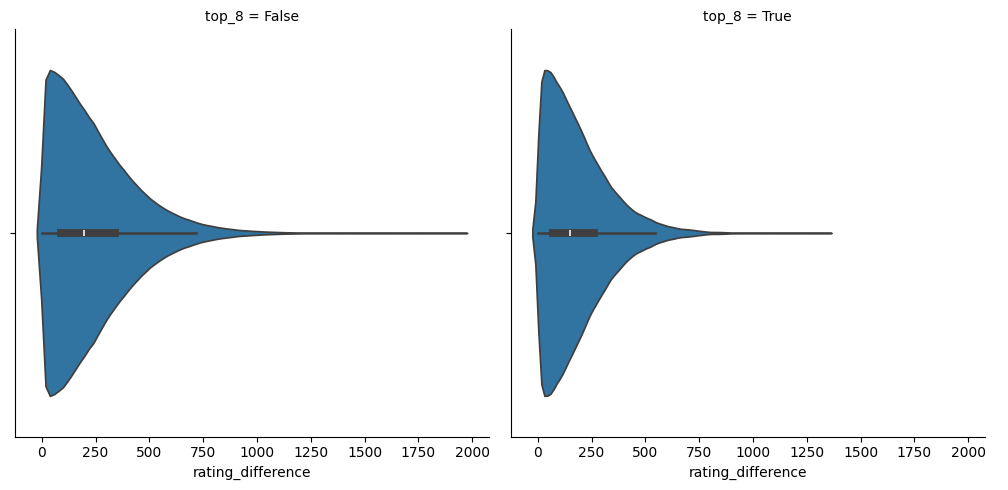

In [38]:
sns.catplot(data=tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['rating_difference'] > 0], x='rating_difference', col='top_8', kind='violin')
plt.show()

In [39]:
# Make a deep copy of the dataframe to avoid the warning
tournament_sets_with_top_8_df = tournament_sets_with_top_8_df.copy()
tournament_sets_with_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['rating_difference'] > 1]

# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['higher_rated_won'] = (
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) & 
     (tournament_sets_with_top_8_df['p1_rating'] > tournament_sets_with_top_8_df['p2_rating'])) |
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p2_id']) & 
     (tournament_sets_with_top_8_df['p2_rating'] > tournament_sets_with_top_8_df['p1_rating']))
)
print(tournament_sets_with_top_8_df.shape)
# tournament_sets_with_top_8_df.info()

(1657512, 23)


In [40]:
print(f"Overall rating baseline: {tournament_sets_with_top_8_df['higher_rated_won'].sum() / tournament_sets_with_top_8_df.shape[0]:.2%}")

top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == True]
print(f"Top 8 rating baseline: {top_8_df['higher_rated_won'].sum() / top_8_df.shape[0]:.2%}")
non_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == False]
print(f"Non top 8 rating baseline: {non_top_8_df['higher_rated_won'].sum() / non_top_8_df.shape[0]:.2%}")


Overall rating baseline: 75.02%
Top 8 rating baseline: 73.83%
Non top 8 rating baseline: 75.22%


In [41]:
# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['more_updates_won'] = (
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) & 
     (tournament_sets_with_top_8_df['p1_updates'] > tournament_sets_with_top_8_df['p2_updates'])) |
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p2_id']) & 
     (tournament_sets_with_top_8_df['p2_updates'] > tournament_sets_with_top_8_df['p1_updates']))
)

In [42]:
top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == True]
print(f"Top 8 updates baseline: {top_8_df['more_updates_won'].sum() / top_8_df.shape[0]:.0%}")
non_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == False]
print(f"Non top 8 updates baseline: {non_top_8_df['more_updates_won'].sum() / non_top_8_df.shape[0]:.0%}")

Top 8 updates baseline: 59%
Non top 8 updates baseline: 64%


In [43]:
# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['p1_won'] = (tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) 



In [44]:
print(f"Player 1 won {tournament_sets_with_top_8_df['p1_won'].sum() / tournament_sets_with_top_8_df.shape[0]:.1%} of the time.")

Player 1 won 70.4% of the time.


In [45]:
# tournament_sets_with_top_8_df.to_pickle(data_path + 'tournament_sets_with_top_8_df.pkl')

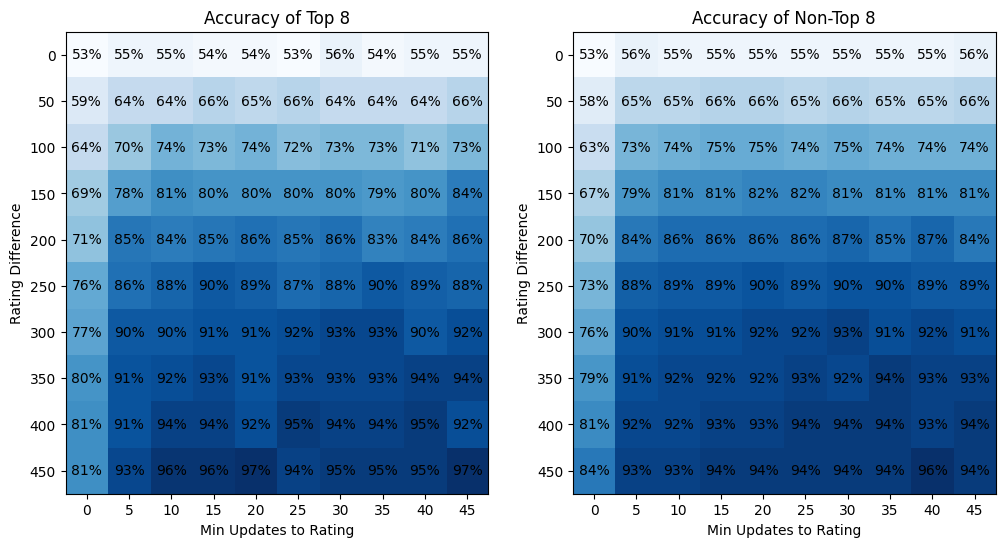

In [46]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p2_updates'], top_8_df['p1_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range


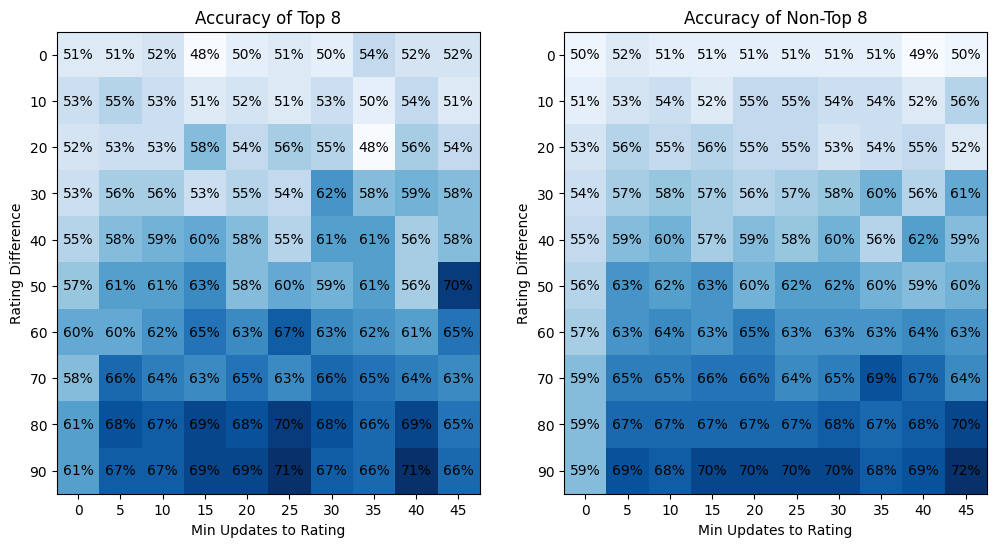

In [47]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range

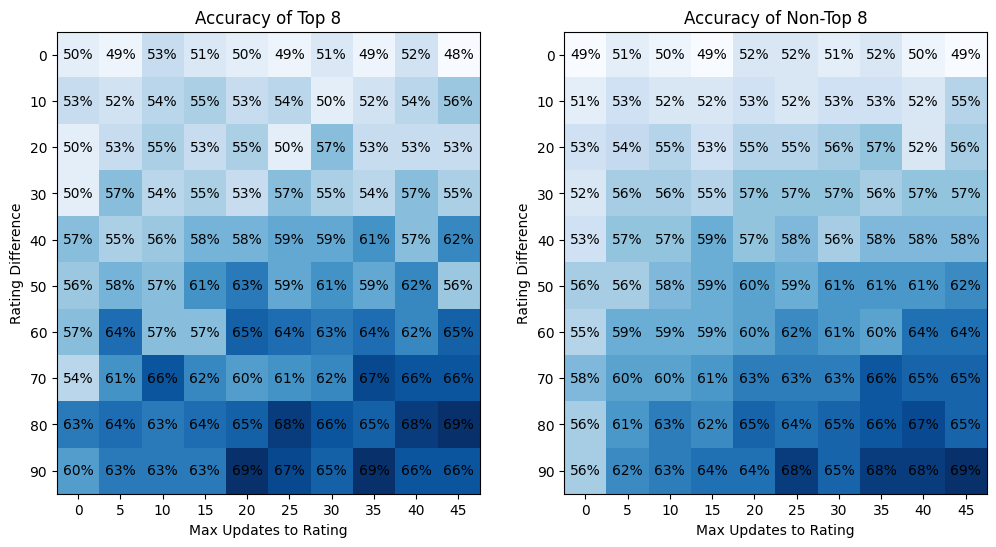

In [48]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range

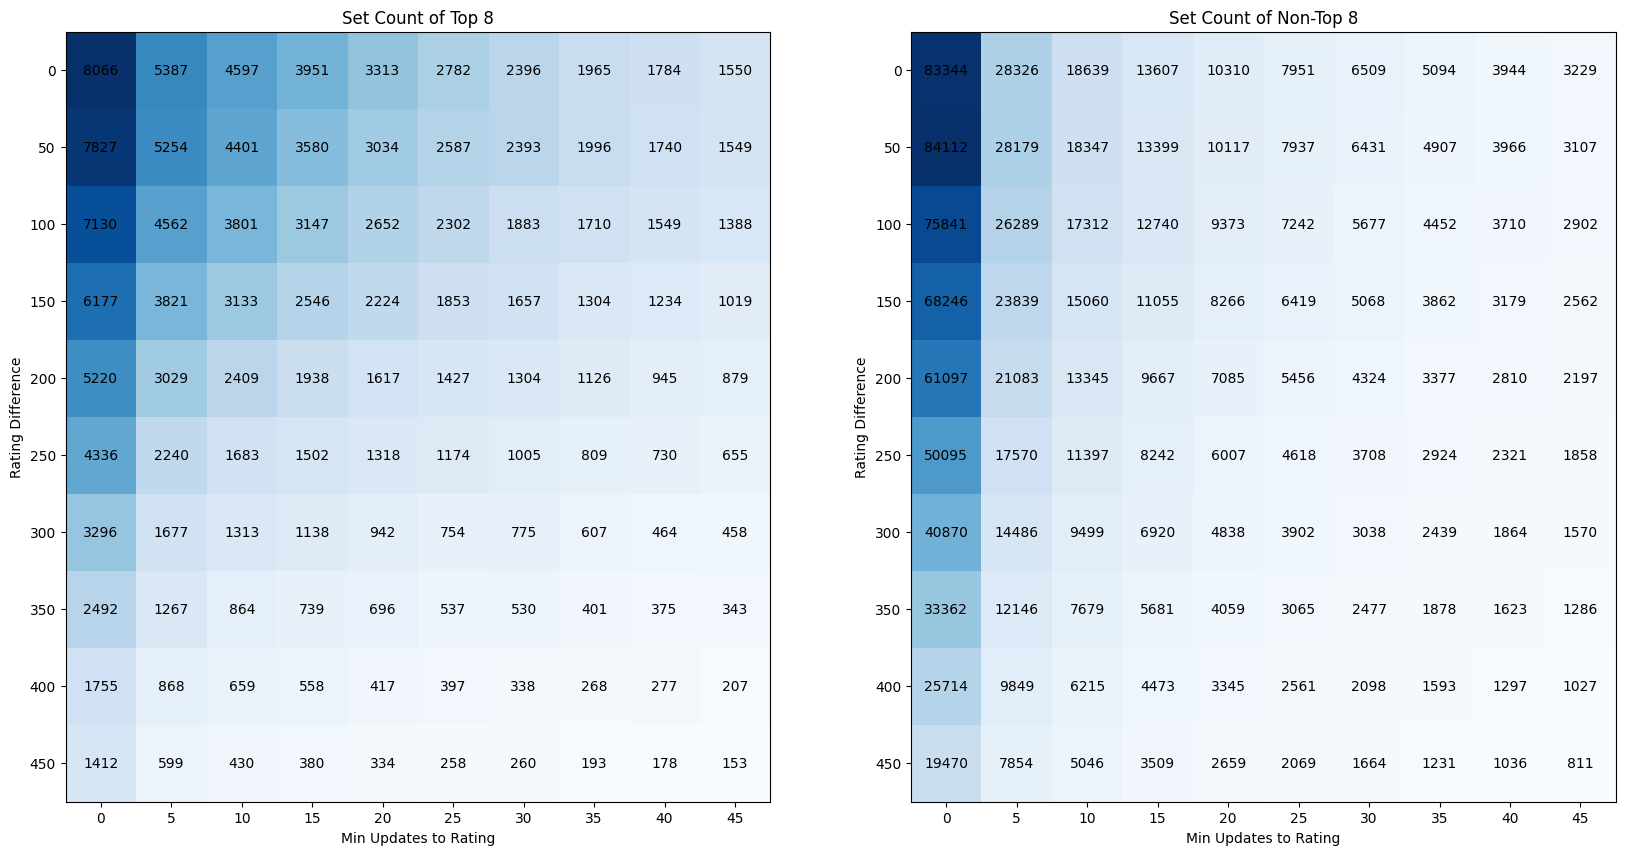

In [49]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range


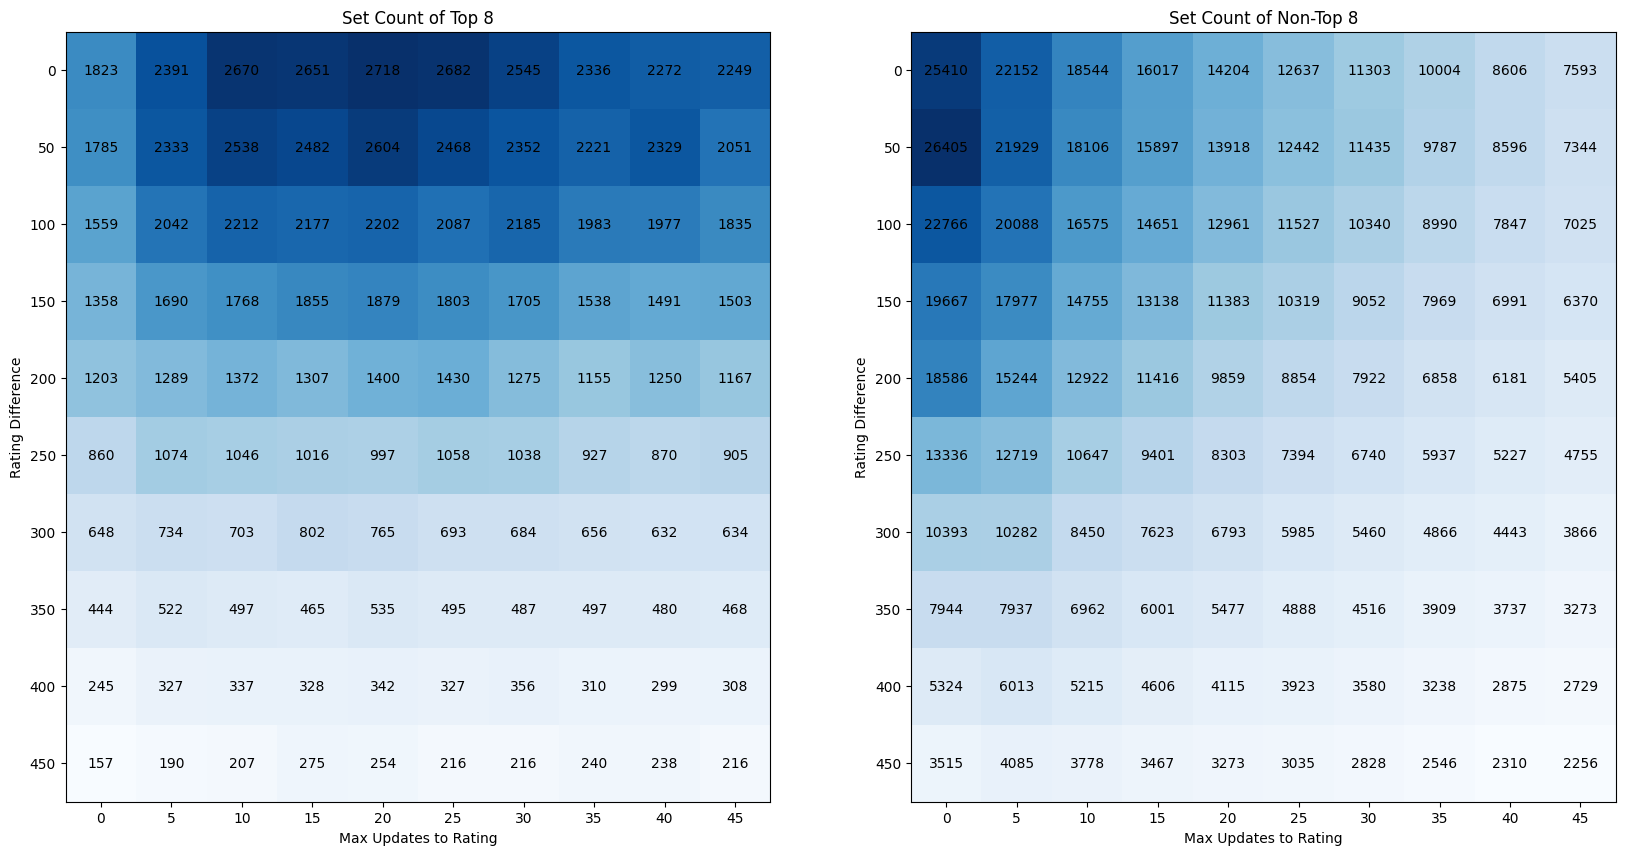

In [50]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range

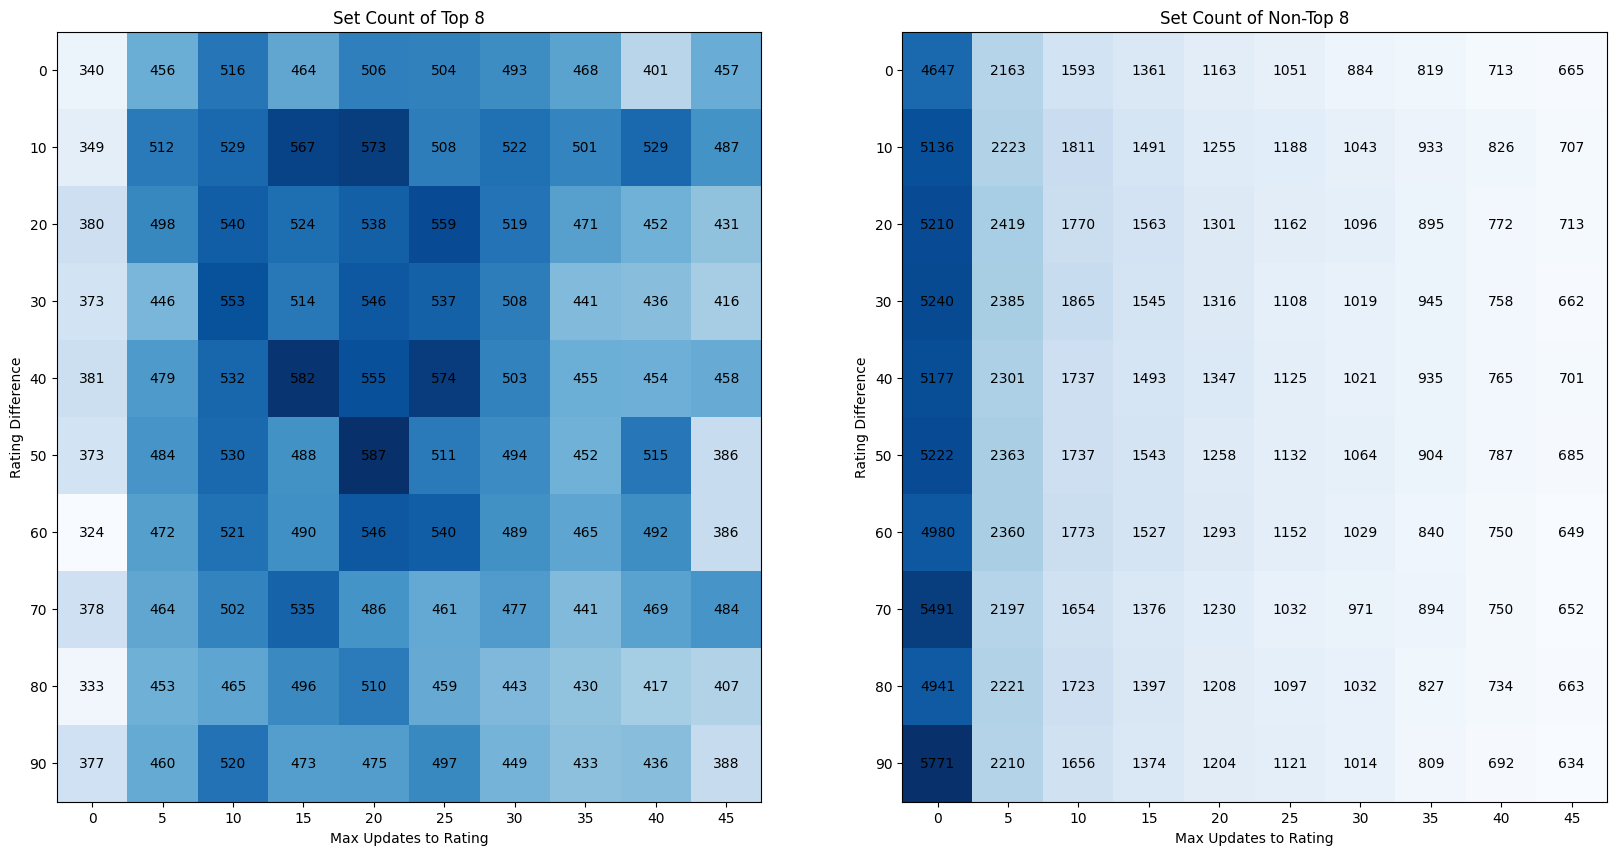

In [51]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p2_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range


## Glicko-2 updated weekly

In [52]:
player_ratings_df = pd.read_pickle(data_path + 'overall_players_ranking_new_weekly.pkl')
player_ratings_df.shape

(515, 96524)

4100162    2540.638681
2863112    2558.813346
3729832    2563.525648
134437     2564.606809
1004       2568.958034
2451533    2577.240484
19554      2597.080311
3733507    2609.697968
1161026    2615.934864
3446738    2669.716959
3895681    2688.624598
3877314    2697.713383
3861397    2709.802203
148442     2719.808087
528367     2729.019484
4118744    2734.613592
2667095    2988.769109
2214938    3275.285899
3217589    3390.609389
3331888    3532.230236
dtype: float64
count    96524.000000
mean      1546.174094
std        107.754486
min       1500.000000
25%       1500.000000
50%       1500.000000
75%       1529.510416
max       3532.230236
dtype: float64
68720


<Axes: >

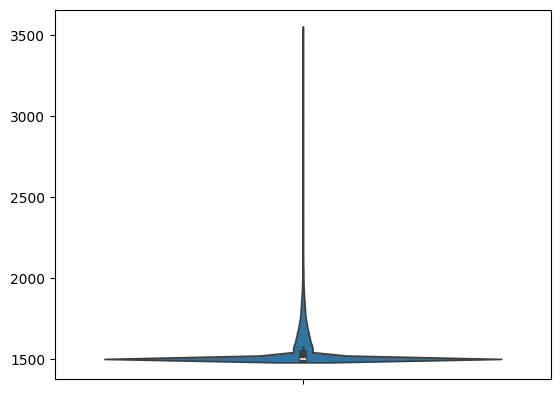

In [53]:

print(player_ratings_df.max().sort_values()[-20:])
print(player_ratings_df.max().describe())
print(sum(player_ratings_df.max() == 1500))
sns.violinplot(player_ratings_df.max())


## Matchup specfic Glicko-2 ##

In [54]:
matchup_glicko = pd.read_pickle(data_path + 'player_ratings_matchup_df.pkl')
matchup_glicko.head()

,player_id,dates_dict,rating_history_dict,rd_history_dict,game_count_dict,glicko2_dict
0,4643,{'melee/jigglypuff': {'melee/falco': [2015-04-...,{'melee/jigglypuff': {'melee/falco': [1799.625...,{'melee/jigglypuff': {'melee/falco': [227.7354...,"{'melee/jigglypuff': {'melee/falco': 3, 'melee...",{'melee/jigglypuff': {'melee/zelda': <glicko2....
1,4005,{'melee/mario': {'melee/falco': [2015-04-13 05...,{'melee/mario': {'melee/falco': [1799.62583569...,{'melee/mario': {'melee/falco': [227.735414619...,"{'melee/mario': {'melee/falco': 3, 'melee/jigg...",{'melee/mario': {'melee/marth': <glicko2.glick...
2,4624,{'melee/jigglypuff': {'melee/pikachu': [2015-0...,{'melee/jigglypuff': {'melee/pikachu': [1747.3...,{'melee/jigglypuff': {'melee/pikachu': [253.40...,"{'melee/jigglypuff': {'melee/pikachu': 2}, 'me...",{'melee/zelda': {'melee/pikachu': <glicko2.gli...
3,4469,{'melee/falco': {'melee/marth': [2015-04-13 05...,{'melee/falco': {'melee/marth': [1747.31808324...,{'melee/falco': {'melee/marth': [253.404608225...,"{'melee/falco': {'melee/marth': 2, 'melee/pika...",{'melee/marth': {'melee/jigglypuff': <glicko2....
4,6189,{'melee/falco': {'melee/fox': [2015-04-13 05:0...,{'melee/falco': {'melee/fox': [1662.3108949761...,{'melee/falco': {'melee/fox': [290.31896467475...,"{'melee/falco': {'melee/fox': 2, 'melee/peach'...",{'melee/fox': {'melee/zelda': <glicko2.glicko2...


In [124]:
matchup_glicko = pd.read_pickle(data_path + 'char_vs_char_player_rankings_weekly_alt.pkl')
matchup_glicko_2 = pd.read_pickle(data_path + 'char_vs_char_player_rankings_weekly_alt2.pkl')
player_ratings_df = pd.read_pickle(data_path + 'overall_players_ranking_new_weekly.pkl')
matchup_glicko.head()

,216922/fox/ganondorf,216922/fox/iceclimbers,216922/fox/jigglypuff,216922/fox/luigi,216922/fox/marth,216922/fox/mewtwo,216922/fox/peach,216922/fox/pichu,216922/fox/pikachu,216922/fox/samus,...,1631943/marth/ganondorf,1631943/marth/jigglypuff,1631943/marth/luigi,1631943/marth/marth,1631943/marth/mewtwo,1631943/marth/peach,1631943/marth/pikachu,1631943/marth/sheik,1631943/marth/younglink,1632067/falco/marth
2015-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-08,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-15,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-22,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-29,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


## aMSa v Cody rating ##
Here we plot aMSa's vs Fox and Cody's vs Yoshi. Cody pretty much always beats aMSa and I would expect that his Fox vs Yoshi matchup rating to be higher than aMSa's Yoshi vs Fox rating. We need to understand why the ratings do not reflect the results.

In [125]:
player_ratings_df

,1617201,1497667,2653190,3657740,41449,6039,3621289,3682293,3332271,2034855,...,1911774,4106746,Black hayato,The boy,138692,3293641,1701726,2408932,SmyD,15495
2015-01-01,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
2015-01-08,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
2015-01-15,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
2015-01-22,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
2015-01-29,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-10,1305.337441,878.580454,1317.650147,991.458742,1508.998406,1362.829389,1599.875264,833.386711,1315.167502,1217.930534,...,1352.175467,1337.532609,1337.689105,1400.124736,1397.772865,1731.792218,1025.048196,1514.677506,1559.078031,1482.878104
2024-10-17,1305.337441,878.580454,1317.650147,991.458742,1508.998406,1362.829389,1599.875264,833.386711,1315.167502,1217.930534,...,1352.175467,1337.532609,1337.689105,1400.124736,1397.772865,1731.792218,1025.048196,1514.677506,1559.078031,1482.878104
2024-10-24,1305.337441,878.580454,1317.650147,991.458742,1508.998406,1362.829389,1599.875264,833.386711,1315.167502,1217.930534,...,1352.175467,1337.532609,1337.689105,1400.124736,1397.772865,1731.792218,1025.048196,1514.677506,1559.078031,1482.878104
2024-10-31,1305.337441,878.580454,1317.650147,991.458742,1508.998406,1362.829389,1599.875264,833.386711,1315.167502,1217.930534,...,1352.175467,1337.532609,1337.689105,1400.124736,1397.772865,1731.792218,1025.048196,1514.677506,1559.078031,1482.878104


In [151]:
print('rating')
print('aMSa', player_ratings_df.iloc[-50]['1021'])
print('Cody', player_ratings_df.iloc[-50]['19554'])
print('Mang0', player_ratings_df.iloc[-50]['1000'])
print('Zain', player_ratings_df.iloc[-50]['6126'])
# print()
# print('alt')
# print('aMSa/yoshi/fox', matchup_glicko.iloc[-50]['1021/yoshi/fox'])
# print('aMSa/yoshi/falco', matchup_glicko.iloc[-50]['1021/yoshi/falco'])
# print('Cody/fox/yoshi', matchup_glicko.iloc[-50]['19554/fox/yoshi'])
# print('Cody/fox/falco', matchup_glicko.iloc[-50]['19554/fox/falco'])
# print('Mang0/falco/yoshi', matchup_glicko.iloc[-50]['1000/falco/yoshi'])
# print('Mang0/fox/yoshi', matchup_glicko.iloc[-50]['1000/fox/yoshi'])
# print('Mang0/falco/fox', matchup_glicko.iloc[-50]['1000/falco/fox'])

print()
print('alt2')
print('aMSa/yoshi/fox', matchup_glicko_2.iloc[-50]['1021/yoshi/fox'])
print('aMSa/yoshi/falco', matchup_glicko_2.iloc[-50]['1021/yoshi/falco'])
print('aMSa/yoshi/marth', matchup_glicko_2.iloc[-50]['1021/yoshi/marth'])
print()
print('Cody/fox/yoshi', matchup_glicko_2.iloc[-50]['19554/fox/yoshi'])
print('Cody/fox/falco', matchup_glicko_2.iloc[-50]['19554/fox/falco'])
print('Cody/fox/marth', matchup_glicko_2.iloc[-50]['19554/fox/marth'])
print()
print('Mang0/falco/yoshi', matchup_glicko_2.iloc[-50]['1000/falco/yoshi'])
print('Mang0/fox/yoshi', matchup_glicko_2.iloc[-50]['1000/fox/yoshi'])
print('Mang0/falco/fox', matchup_glicko_2.iloc[-50]['1000/falco/fox'])
print('Mang0/falco/marth', matchup_glicko_2.iloc[-50]['1000/falco/marth'])
print()
print('Zain/marth/yoshi', matchup_glicko_2.iloc[-50]['6126/marth/yoshi'])
print('Zain/marth/fox', matchup_glicko_2.iloc[-50]['6126/marth/fox'])
print('Zain/marth/falco', matchup_glicko_2.iloc[-50]['6126/marth/falco'])
print('Zain/roy/fox', matchup_glicko_2.iloc[-50]['6126/roy/fox'])

rating
aMSa 2505.0481727109
Cody 2571.3415551319567
Mang0 2359.0715491266683
Zain 2372.726329318709

alt2
aMSa/yoshi/fox 2344.349568565844
aMSa/yoshi/falco 2549.393218214499
aMSa/yoshi/marth 2460.5890615358417

Cody/fox/yoshi 2666.0963118040218
Cody/fox/falco 2401.9596390750403
Cody/fox/marth 2388.1975457616504

Mang0/falco/yoshi 2635.9929028055494
Mang0/fox/yoshi 2497.395485615402
Mang0/falco/fox 2483.834803764433
Mang0/falco/marth 2206.8041339741058

Zain/marth/yoshi 2378.9264836369193
Zain/marth/fox 2547.110421515839
Zain/marth/falco 2439.4534618401635
Zain/roy/fox 2046.1459068719703


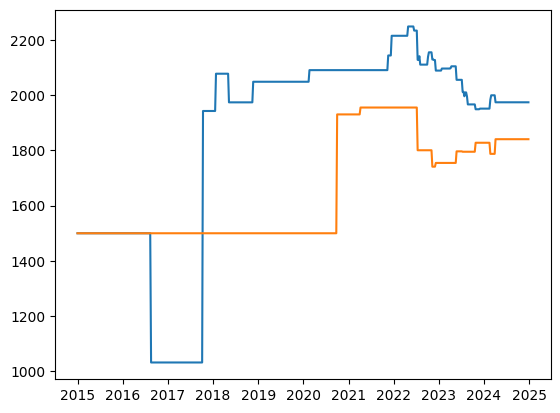

In [84]:
aMSa = matchup_glicko.iloc[:]['1021/yoshi/fox']
Cody = matchup_glicko.iloc[:]['19554/fox/yoshi']
plt.plot(aMSa)
plt.plot(Cody)

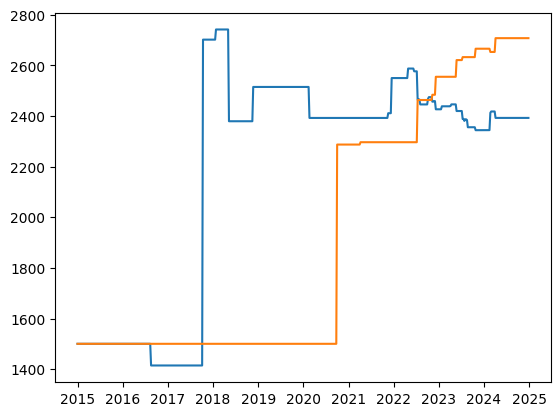

In [ ]:
aMSa = matchup_glicko_2.iloc[:]['1021/yoshi/fox']
Cody = matchup_glicko_2.iloc[:]['19554/fox/yoshi']
plt.plot(aMSa)
plt.plot(Cody)
plt.title('aMSa & Cody')

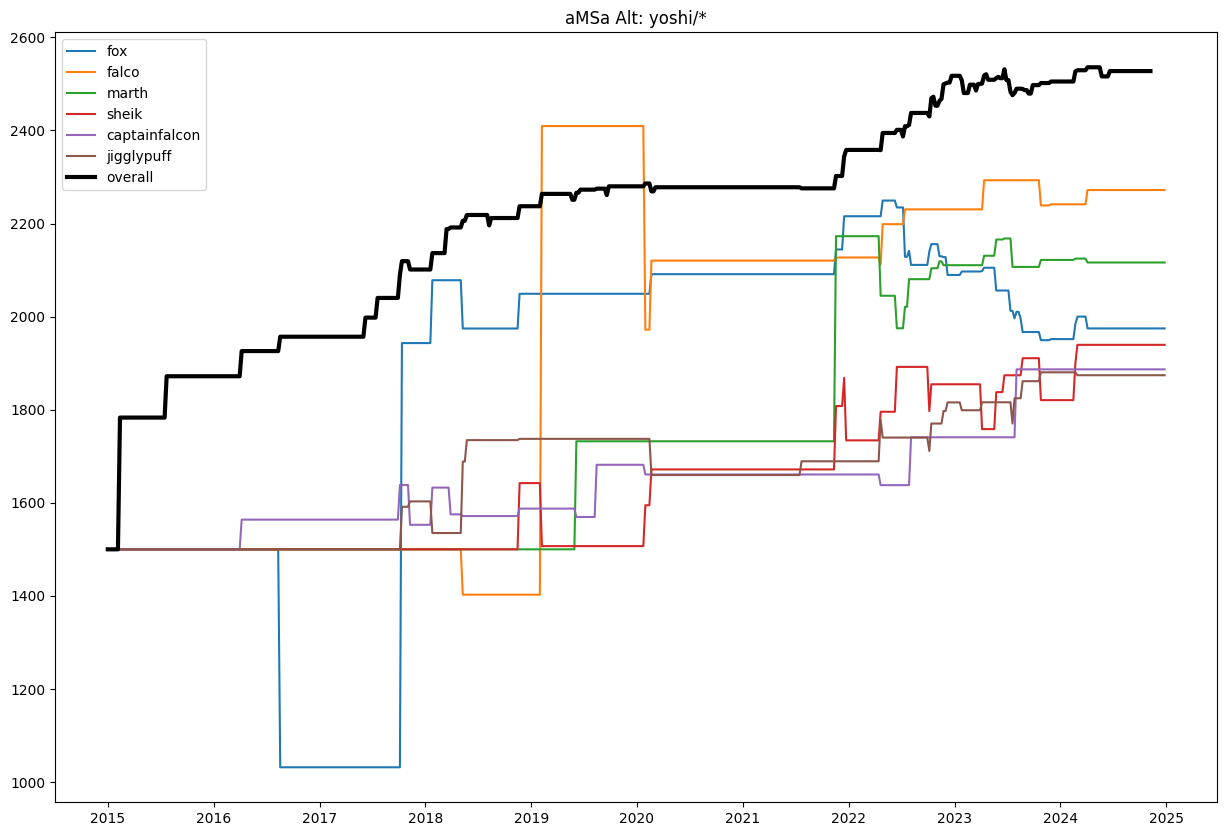

In [116]:
characters = list(sorted_characters.keys())
characters
plt.figure(figsize=(15,10))
plt.title('aMSa Alt: yoshi/*')
for character in characters[:6]:
    plt.plot(matchup_glicko.iloc[:][f'1021/yoshi/{character}'], label=character)
plt.plot(player_ratings_df['1021'], color='black', linewidth=3, label='overall')
plt.legend()

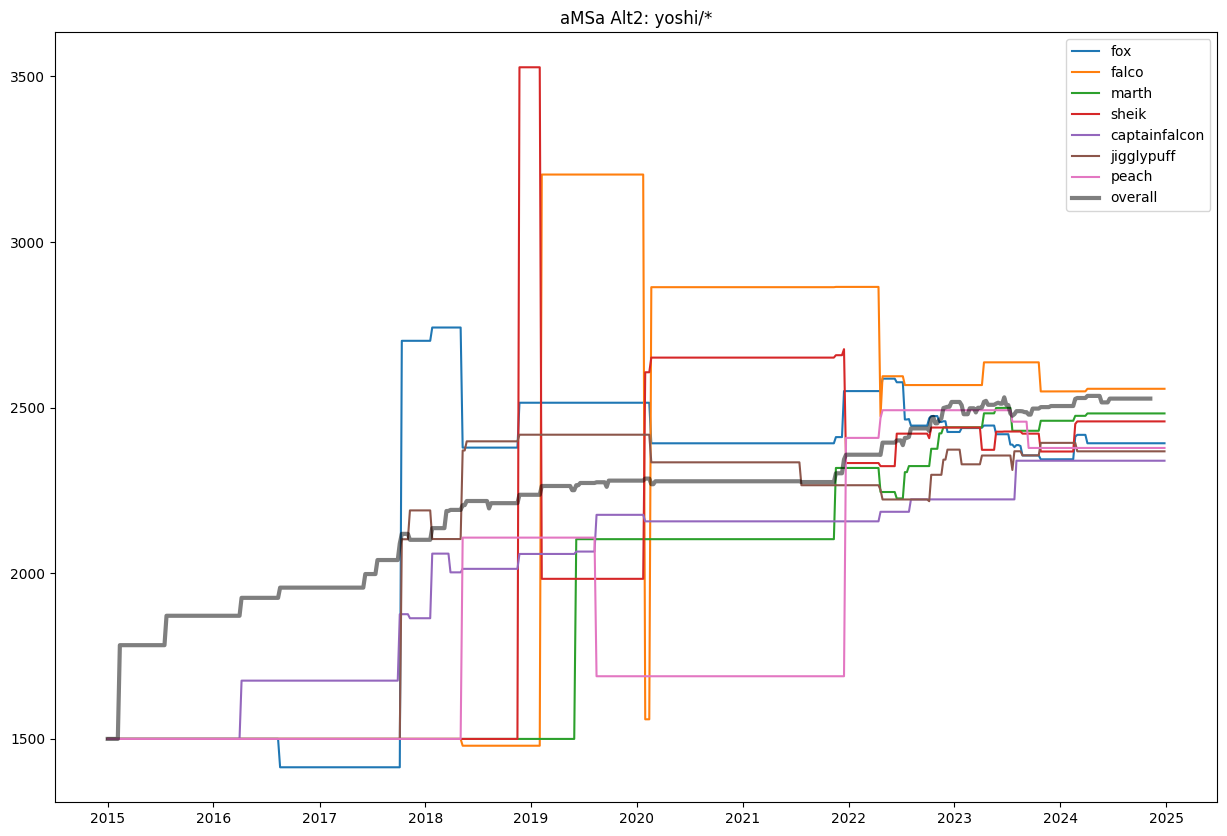

In [139]:
characters = list(sorted_characters.keys())
characters
plt.figure(figsize=(15,10))
plt.title('aMSa Alt2: yoshi/*')
for character in characters[:7]:
    plt.plot(matchup_glicko_2.iloc[:][f'1021/yoshi/{character}'], label=character)
plt.plot(player_ratings_df['1021'], color='black', linewidth=3, label='overall', alpha=.5)
plt.legend()

,1617201,1497667,2653190,3657740,41449,6039,3621289,3682293,3332271,2034855,...,1911774,4106746,Black hayato,The boy,138692,3293641,1701726,2408932,SmyD,15495
2015-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-08,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-15,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-22,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-29,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


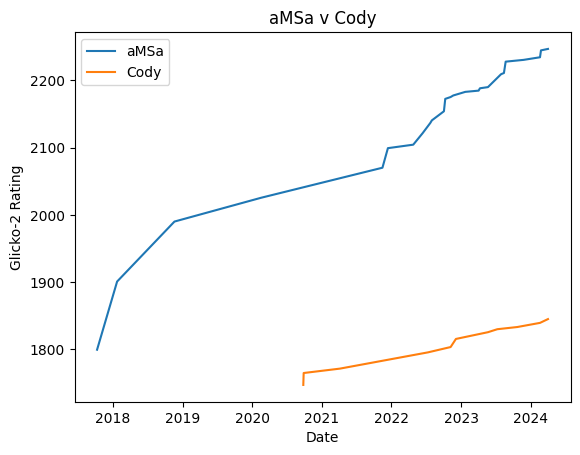

In [55]:
# Extract the relevant row from the DataFrame
player_data = matchup_glicko.loc[matchup_glicko['player_id'] == '1021', 'rating_history_dict'].values[0]
date_value = matchup_glicko.loc[matchup_glicko['player_id'] == '1021', 'dates_dict'].values[0]
# Access the specific nested data: melee/yoshi vs melee/fox
yoshi_vs_fox_ratings = player_data['melee/yoshi']['melee/fox']

plt.figure()
plt.plot(date_value['melee/yoshi']['melee/fox'], player_data['melee/yoshi']['melee/fox'], label='aMSa')

# Extract the relevant row from the DataFrame
player_data = matchup_glicko.loc[matchup_glicko['player_id'] == '19554', 'rating_history_dict'].values[0]
date_value = matchup_glicko.loc[matchup_glicko['player_id'] == '19554', 'dates_dict'].values[0]
# Access the specific nested data: melee/yoshi vs melee/fox
fox_vs_yoshi_ratings = player_data['melee/fox']['melee/yoshi']
plt.title('aMSa v Cody')
plt.xlabel('Date')
plt.ylabel('Glicko-2 Rating')

plt.plot(date_value['melee/fox']['melee/yoshi'], player_data['melee/fox']['melee/yoshi'], label='Cody')
plt.legend()
plt.show()

In [56]:
matchup_glicko.loc[matchup_glicko['player_id'] == '1021', 'game_count_dict'].values[0]['melee/yoshi']['melee/fox']

98

In [57]:
matchup_glicko.loc[matchup_glicko['player_id'] == '19554', 'game_count_dict'].values[0]['melee/fox']['melee/yoshi']

45

In [58]:
# # Define the player and opponent characters
# player_character = 'melee/fox'
# opponent_character = 'melee/falco'



# def get_matchup(matchup_glicko, player_character, opponent_character):
#     # Safely access nested dictionaries with error handling
#     def extract_dates(nested_dict):
#         """Safely extract the dates for a given player and opponent matchup."""
#         try:
#             # Extract the dates if both keys are present
#             return nested_dict.get(player_character, {}).get(opponent_character, [])
#         except AttributeError:
#             # Handle cases where the structure is not as expected
#             return []  # Default fallback
        
#     # Copy the original DataFrame
#     glicko2_matchup = matchup_glicko.copy()
    
#     # Apply the extraction function
#     glicko2_matchup['dates'] = glicko2_matchup['dates_dict'].apply(extract_dates)
#     glicko2_matchup['rating_history'] = glicko2_matchup['rating_history_dict'].apply(extract_dates)
#     glicko2_matchup['rd_history'] = glicko2_matchup['rating_history_dict'].apply(extract_dates)
#     # glicko2_matchup['extracted_dates'] = glicko2_matchup['dates_dict'].apply(extract_dates)

#     # glicko2_matchup.

#     # Check the first few rows to verify the result
#     # print(glicko2_matchup[['player_id','dates_dict', 'extracted_dates','extracted_rating']].head())
#     glicko2_matchup_filtered = glicko2_matchup[glicko2_matchup['dates'].apply(len) > 0][['player_id','dates', 'rating_history','rd_history']]
#     glicko2_matchup_filtered.set_index(glicko2_matchup_filtered['player_id'], inplace=True)

#     return glicko2_matchup_filtered[['dates', 'rating_history','rd_history']]

# def get_index_of_date(dates, target_date):
#     return np.searchsorted(dates, target_date) - 1


# print(get_matchup(matchup_glicko,'melee/fox', 'melee/falco'))
# # print(glicko2_df)

# def print_top_players(glicko2_df, n_players = 5):
#     for year in range(2016, 2025):
#         for month in [1, 6]:
#             # First filter out the players who have only a few updates (played in 5 tournaments)
#             filtered_glicko = glicko2_df[glicko2_df['dates'].apply(len) > 4]
            
#             target_date = datetime.datetime(year, month, 1)

#             indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
            
#             # Filter out the players that have not entered a tournament yet.
#             filtered_glicko = filtered_glicko[indices > 0]

#             # Extract ratings as a Series, ensuring correct data type
#             # print(indices)
#             ratings_on_date = filtered_glicko.apply(
#                 lambda row: row['rating_history'][indices[row.name]], axis=1
#             )

#             rd_on_date = filtered_glicko.apply(
#                 lambda row: row['rd_history'][indices[row.name]], axis=1
#             )

#             # Ensure ratings_on_date is a Series and sort it
#             top_5 = ratings_on_date.sort_values(ascending=False)[:n_players]

#             # Retrieve the player tags along with their ratings
#             top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
#             top_5_df = top_5_df.set_index('player_id').loc[top_5.index]

#             top_5_df['rating'] = top_5.values.astype(int)

#             # Display the top 5 players sorted by rating
#             print(f"Date: {target_date.strftime('%Y-%m-%d')}")
#             print(top_5_df[['tag', 'rating']].to_string(index=False))
#             print()


# # Example usage: print top players for Fox vs Falco
# print_top_players(get_matchup(matchup_glicko, 'melee/fox', 'melee/falco'), 10)

# # get_matchup(matchup_glicko,'melee/fox', 'melee/falco')

# print_top_players(get_matchup(matchup_glicko,'melee/fox', 'melee/falco'), 10)


This code will visualize the effect of different values of tau in the calculation.

In [59]:
# matchup_glicko_3 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_3_df.pkl')
# matchup_glicko_5 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_5_df.pkl')
# matchup_glicko_7 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_7_df.pkl')
# matchup_glicko_9 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_9_df.pkl')
# matchup_glicko_11 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_11_df.pkl')
# matchup_glicko_13 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_13_df.pkl')


In [60]:
# # Extract the relevant row from the DataFrame
# glicko_data_list = [matchup_glicko_3, matchup_glicko_5, matchup_glicko_7, matchup_glicko_9, matchup_glicko_11, matchup_glicko_13]
# # glicko_data_list = [matchup_glicko_3, matchup_glicko_5]
# titles  = ['tau = .3', 'tau = .5', 'tau = .7', 'tau = .9', 'tau = 1.1', 'tau = 1.3']

# # Create subplots
# fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# # Add a main title to the figure
# fig.suptitle('aMSa and Cody matchup rating by tau', fontsize=16)


# for i, data in enumerate(glicko_data_list):
#     amsa_matchup = data.loc[data['player_id'] == '1021']
#     cody_matchup = data.loc[data['player_id'] == '19554']
    
#     amsa_dates = amsa_matchup['dates_dict'].values[0]['melee/yoshi']['melee/fox']
#     cody_dates = cody_matchup['dates_dict'].values[0]['melee/fox']['melee/yoshi']
    
#     amsa_ratings = amsa_matchup['rating_history_dict'].values[0]['melee/yoshi']['melee/fox']
#     cody_ratings = cody_matchup['rating_history_dict'].values[0]['melee/fox']['melee/yoshi']
    
#     # Determine the subplot position in the 3x2 grid
#     row, col = divmod(i, 2)
    
#     ax[row, col].plot(amsa_dates, amsa_ratings, label='aMSa')
#     ax[row, col].plot(cody_dates, cody_ratings, label='Cody')
#     ax[row, col].legend()
#     ax[row, col].set_title(titles[i])


